In [1]:
%load_ext rpy2.ipython

from cap2.capalyzer.pangea import PangeaFileSource
from cap2.capalyzer.pangea.utils import get_pangea_group
from cap2.capalyzer.table_builder import CAPTableBuilder

from plotnine import *
import pandas as pd
import warnings
from glob import glob
from os.path import isfile
fro os import environ

warnings.filterwarnings('ignore')

twins_group = get_pangea_group('Mason Lab', 'NASA Twins', 'dcdanko@gmail.com', environ.get('PANGEA_PASS'))
twins_source = PangeaFileSource(twins_group)
twins = CAPTableBuilder('twins', twins_source)
iss_group = get_pangea_group('Mason Lab', 'NASA ISS', 'dcdanko@gmail.com', environ.get('PANGEA_PASS'))
iss_source = PangeaFileSource(iss_group)
iss = CAPTableBuilder('iss', iss_source)


In [2]:
meta = twins.metadata()
iss_meta = iss.metadata()

def getit(val, x):
    try:
        return meta.loc[x, val]
    except KeyError:
        if x in iss_meta.index:
            return 'ISS'
        return None

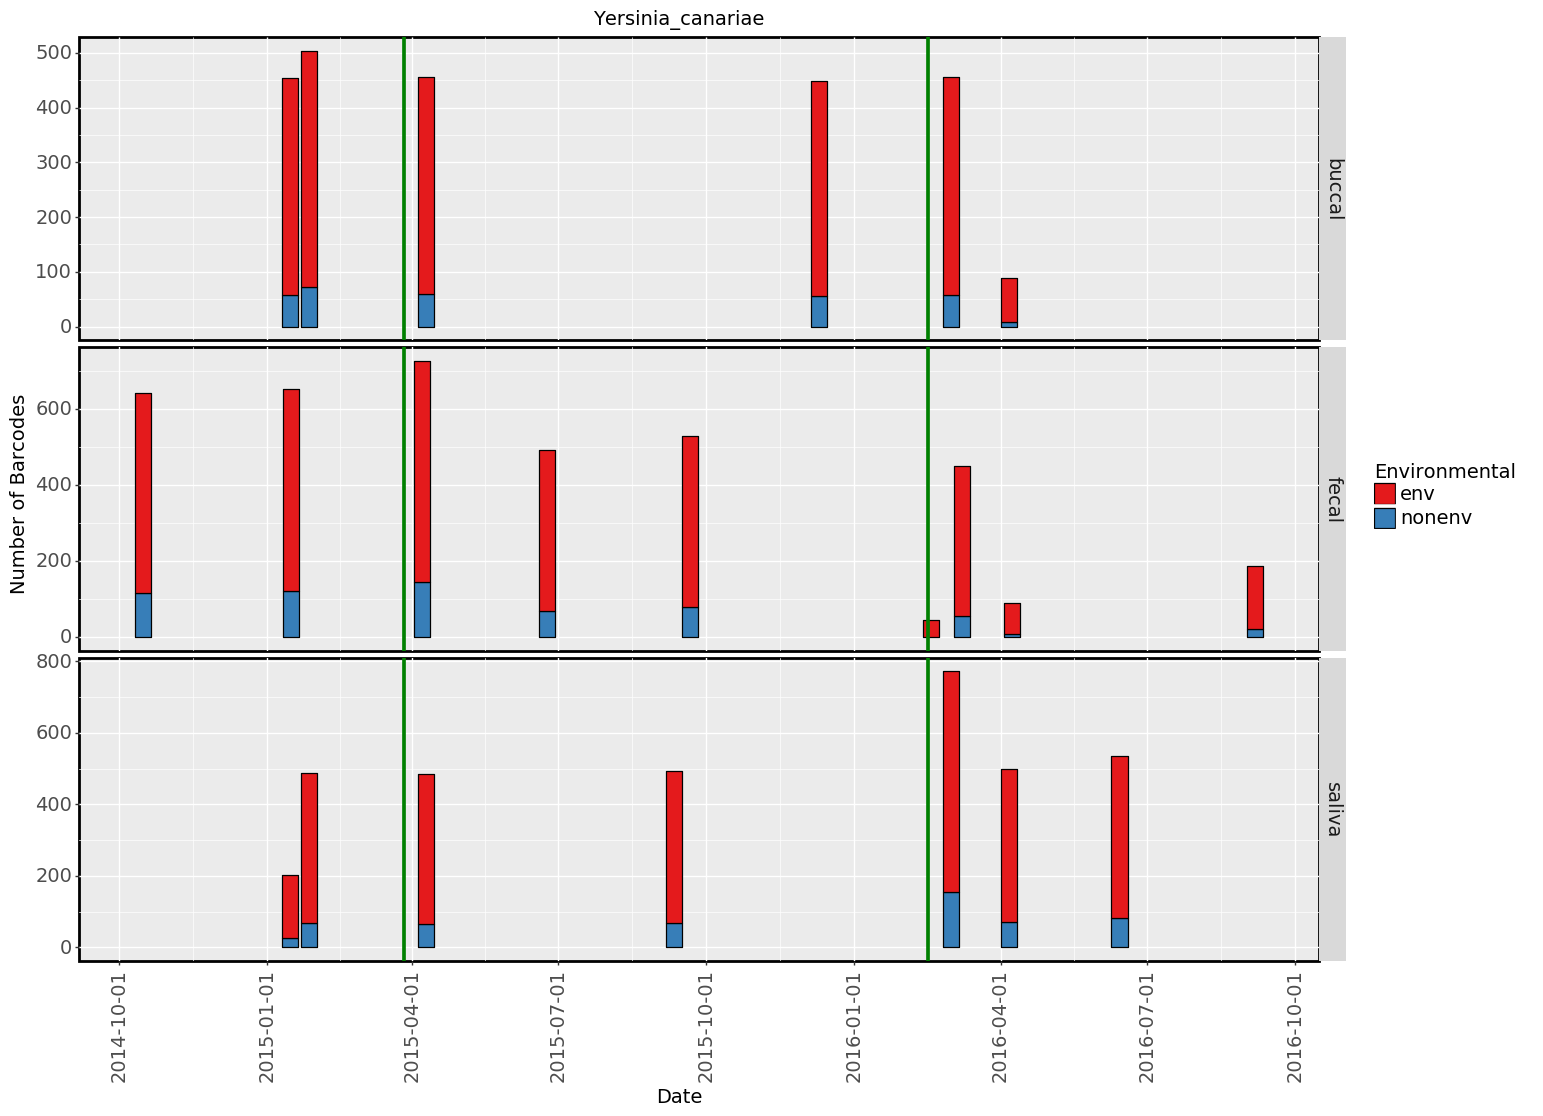

<ggplot: (8754140348743)>

In [3]:
from functools import lru_cache

@lru_cache(maxsize=128)
def _get_wide_table(organism):
    return pd.read_csv(f'graphs/v1/{organism}/{organism}.wide_table.csv', index_col=0)

def get_wide_table(organism):
    return _get_wide_table(organism).copy()

def summary_table(tbl):
    comps = tbl.copy().fillna(0)
    comps['flight'] = comps.index.map(lambda x: getit('flight', x))
    comps = comps.groupby('flight').sum().T
    return comps

def prep_table(foo, env_comps):
    foo['sample_name'] = foo.index
    foo = foo.melt(id_vars='sample_name')
    foo = foo.dropna()
    foo['environmental'] = foo['variable'].map(lambda x: 'env' if x in env_comps else 'nonenv')
    foo = foo.groupby(('sample_name', 'environmental')).sum()
    foo = foo.reset_index()

    foo['date'] = foo['sample_name'].map(lambda x: getit('date', x))
    #foo['date'] = pd.to_datetime(foo['date'])
    foo['kind'] = foo['sample_name'].map(lambda x: getit('kind', x))
    foo['during_flight'] = foo['sample_name'].map(lambda x: getit('during_flight', x))

    foo['subject'] = foo['sample_name'].map(lambda x: getit('subject', x))
    foo = foo.dropna()
    foo = foo.query('subject == "TW"')
    return foo


def snp_barcode_flux(organism):
    tbl = get_wide_table(organism)
    comps = summary_table(tbl)
    env_comps = set(comps.query('ISS > 0').index.to_list())
    tbl = prep_table(tbl, env_comps)
    tbl['organism'] = organism
    return tbl


def plot_one_flux(organism):
    tbl = snp_barcode_flux(organism)
    return (
        ggplot(tbl, aes(x='date', y='value', fill='environmental')) +
            geom_col(width=10, color='black') +
            facet_grid('kind~', scales='free') +
            scale_x_date() +
            scale_fill_brewer(type='qualitative', palette=6, direction=1) +
            xlab(f'Date') +
            ylab(f'Number of Barcodes') +
            labs(fill='Environmental') +
            ggtitle(organism) +
            geom_vline(xintercept='2015-03-27', color='green', size=1.5) +
            geom_vline(xintercept='2016-02-16', color='green', size=1.5) +
            theme(
                text=element_text(size=14),
                axis_text_x=element_text(angle=90),
                legend_position='right',
                panel_border=element_rect(colour="black", fill='none', size=2),
                figure_size=(16, 12),
            )
    )

plot_one_flux('Yersinia_canariae')

In [41]:
def barcode_set(tbl, samples):
    s = tbl.loc[samples].sum()
    s = set(s[s > 0].index)
    return s

def source_barcodes(organism, kind, mymeta, iss_meta, permute=False, twin="TW"):
    tbl = get_wide_table(organism)
    meta = mymeta.loc[set(tbl.index) & set(mymeta.index)]
    meta['sample_name'] = meta.index

    target_samples = meta.query('subject == @twin').query('kind == @kind').query('flight == "flight"').index.to_list()
    sources = meta.query('subject == @twin').query('flight == "before"')
    if permute:
        target_samples = meta.query('subject == @twin').query('kind == @kind').sample(len(target_samples)).index.to_list()
        sources = meta.query('subject == @twin').query('sample_name not in @target_samples').sample(len(sources))

    saliva_sources = sources.query('kind == "saliva"').index.to_list()
    fecal_sources = sources.query('kind == "fecal"').index.to_list()
    iss_sources = set(iss_meta.index.to_list()) & set(tbl.index.to_list())
    source_order = [('fecal', fecal_sources), ('saliva', saliva_sources), ('ISS', iss_sources)]
    if kind == 'saliva':
        source_order = [('saliva', saliva_sources), ('fecal', fecal_sources), ('ISS', iss_sources)]

    bc_source_sets = [(n, barcode_set(tbl, source)) for n, source in source_order]
    mixed_bc_set = bc_source_sets[1][1] & bc_source_sets[2][1]
    bc_source_sets = [
        bc_source_sets[0],
        ('mixed', mixed_bc_set),
        (bc_source_sets[1][0], bc_source_sets[1][1] - mixed_bc_set),
        (bc_source_sets[2][0], bc_source_sets[2][1] - mixed_bc_set),
    ]
    target_bc_set = barcode_set(tbl, target_samples)
    total_bcs = len(target_bc_set) + 1
    out = {}
    for name, bc_set in bc_source_sets:
        out[name] = len(bc_set & target_bc_set) / total_bcs
        target_bc_set -= bc_set
    out['unidentified'] = len(target_bc_set) / total_bcs
    out['organism'] = ' '.join(organism.split('_'))
    out['permuted'] = permute
    out['kind'] = kind
    out['twin'] = twin
    return out

def build_multispecies_source_table(taxa):
    rows = []
    for twin in ['TW']:
        for taxon in taxa:
            for kind in ['fecal', 'saliva']:
                rows.append(source_barcodes(taxon, kind, meta, iss_meta, twin=twin))
    tbl = pd.DataFrame(rows)
    tbl = tbl.melt(id_vars=['permuted', 'kind', 'organism', 'twin'])
    org_order = tbl.query('twin == "TW"').query('kind == "fecal"').query('variable == "ISS"')
    org_order = org_order.sort_values('value')['organism'].to_list()
    tbl['organism'] = pd.Categorical(tbl['organism'], categories=org_order)
    tbl['variable'] = pd.Categorical(tbl['variable'], categories=[
        'unidentified',
        'fecal',
        'saliva',
        'mixed',
        'ISS',
    ])
    return tbl

multi_flux = build_multispecies_source_table([
'Anoxybacillus_amylolyticus',
'Atlantibacter_hermannii',
'Bacillus_albus',
'Bacillus_tequilensis',
'Bacteroides_caccae',
'Bifidobacterium_catenulatum',
'Bifidobacterium_pseudocatenulatum',
'Brenneria_rubrifaciens',
'Brevibacterium_siliguriense',
'Campylobacter_lari',
'Cronobacter_condimenti',
'Exiguobacterium_antarcticum',
'Fusobacterium_necrophorum',
'Geobacillus_stearothermophilus',
'Gluconobacter_albidus',
'Gordonibacter_urolithinfaciens',
'Kosakonia_sacchari',
'Leptotrichia_hongkongensis',
'Pectobacterium_parmentieri',
'Serratia_proteamaculans',
'Staphylococcus_sciuri',
'Staphylococcus_simiae',
'Streptococcus_viridans',
'Vibrio_alginolyticus',
'Yersinia_canariae',
])
multi_flux

,permuted,kind,organism,twin,variable,value
0,False,fecal,Anoxybacillus amylolyticus,TW,fecal,0.012339
1,False,saliva,Anoxybacillus amylolyticus,TW,fecal,0.000130
2,False,fecal,Atlantibacter hermannii,TW,fecal,0.221550
3,False,saliva,Atlantibacter hermannii,TW,fecal,0.884081
4,False,fecal,Bacillus albus,TW,fecal,0.008251
...,...,...,...,...,...,...
245,False,saliva,Streptococcus viridans,TW,unidentified,0.509053
246,False,fecal,Vibrio alginolyticus,TW,unidentified,0.115994
247,False,saliva,Vibrio alginolyticus,TW,unidentified,0.289693
248,False,fecal,Yersinia canariae,TW,unidentified,0.031637


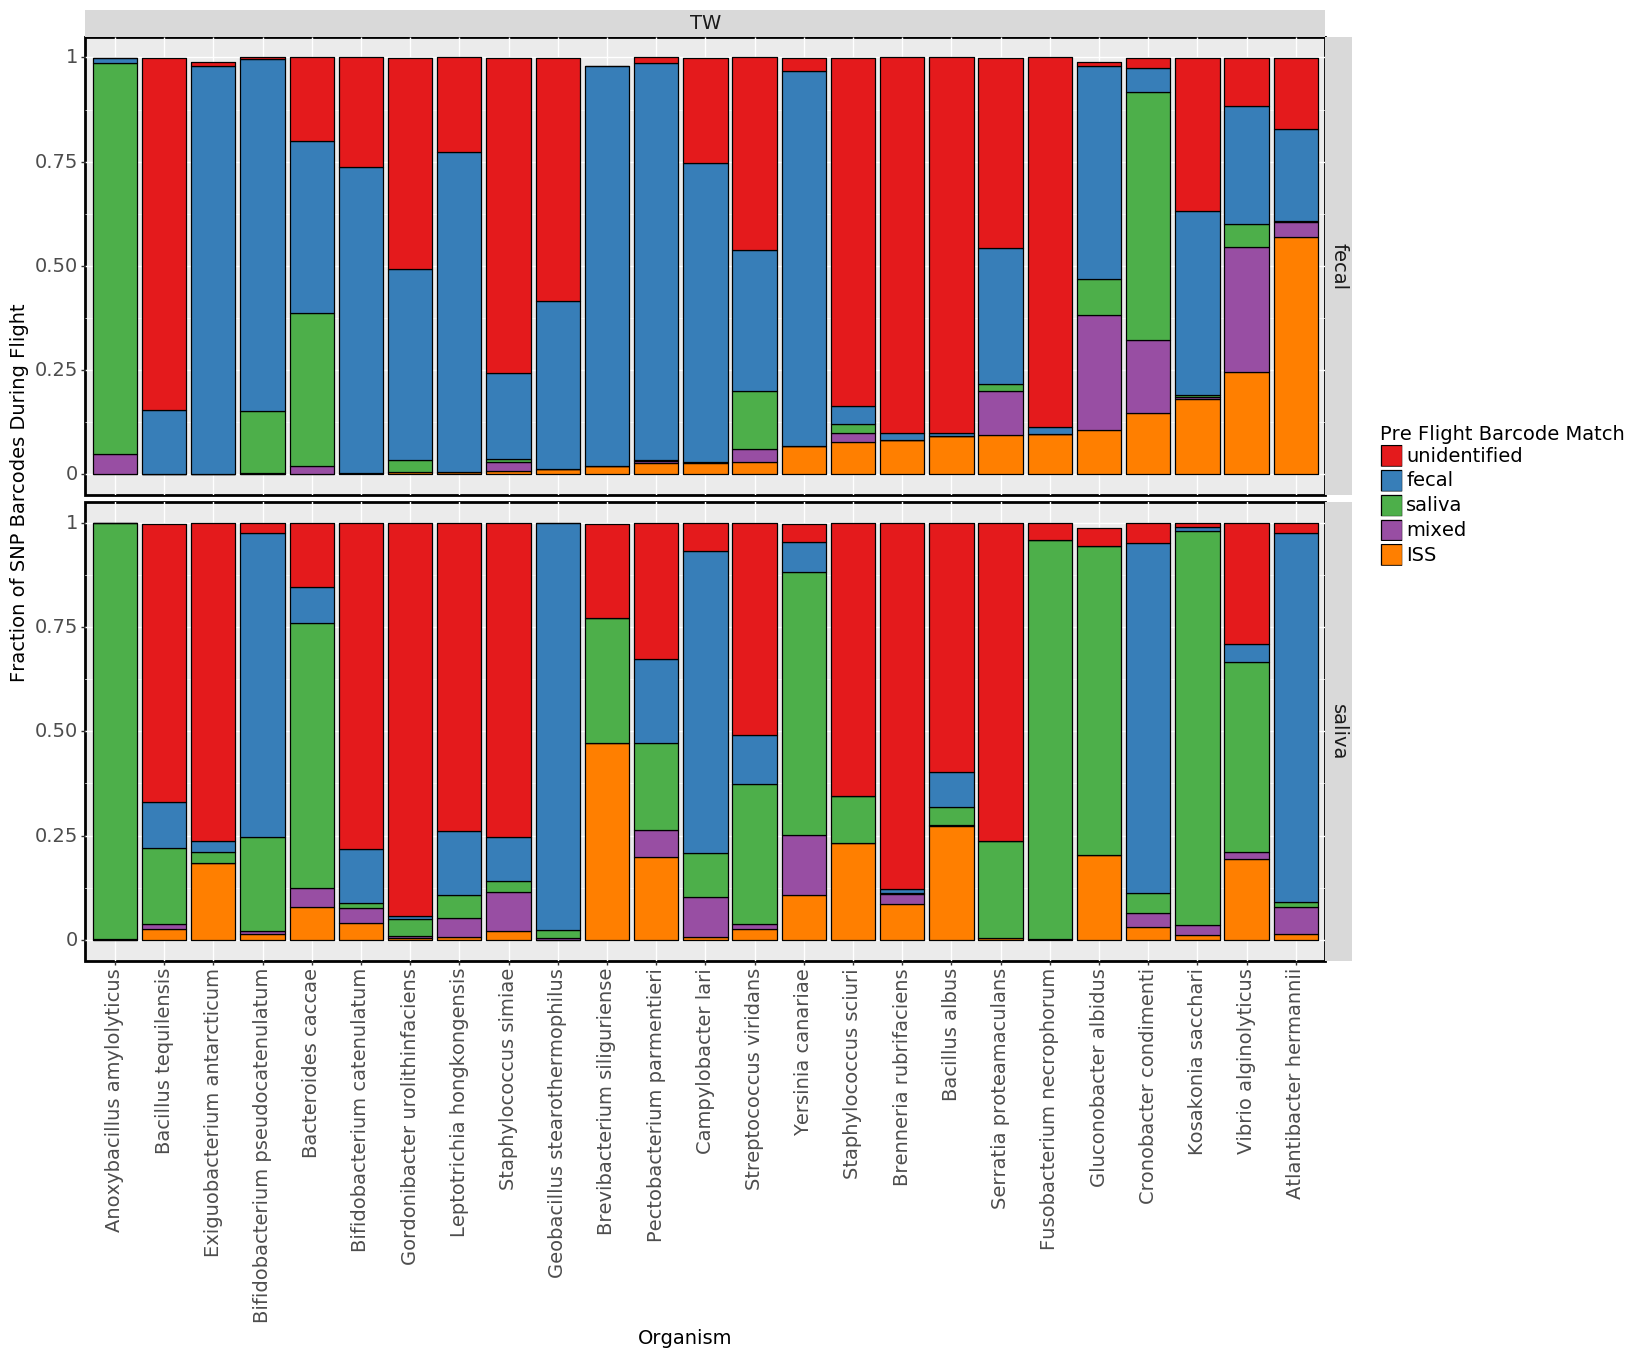

<ggplot: (-9223363282719348178)>

In [45]:
(
    ggplot(multi_flux, aes(x='organism', y='value', fill='variable')) +
        geom_col(color='black') +
        facet_grid('kind~twin', scales='free') +
        scale_fill_brewer(type='qualitative', palette=6, direction=-1) +
        xlab(f'Organism') +
        ylab(f'Fraction of SNP Barcodes During Flight') +
        labs(fill='Pre Flight Barcode Match') +
        theme(
            text=element_text(size=14),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 12),
        )
)

In [34]:
def quantile(val, refs):
    n_below = 0
    for ref in refs:
        if ref < val:
            n_below += 1
    frac_below = n_below / len(refs)
    return frac_below

def permute_multispecies_source_table(taxa, N=10):
    rows = []
    for taxon in taxa:
        for kind in ['fecal', 'saliva']:
            truth = source_barcodes(taxon, kind, meta, iss_meta)
            fakes = []
            for _ in range(N):
                fakes.append(source_barcodes(taxon, kind, meta, iss_meta, permute=True)['ISS'])
            truth['ISS_quantile'] = quantile(truth['ISS'], fakes)
            rows.append(truth)
    tbl = pd.DataFrame(rows)
    tbl = tbl.melt(id_vars=['permuted', 'kind', 'organism', 'twin'])
    org_order = tbl.query('kind == "fecal"').query('variable == "ISS"')
    org_order = org_order.sort_values('value')['organism'].to_list()
    tbl['organism'] = pd.Categorical(tbl['organism'], categories=org_order)
    tbl = tbl.query('twin == "TW"')
    tbl = tbl.query('variable == "ISS_quantile"')
    tbl = tbl.drop(columns=['variable', 'permuted'])
    tbl = tbl.pivot(index='organism', columns='kind', values='value')
    return tbl

multi_permute = permute_multispecies_source_table([
'Anoxybacillus_amylolyticus',
'Atlantibacter_hermannii',
'Bacillus_albus',
'Bacillus_tequilensis',
'Bacteroides_caccae',
'Bifidobacterium_catenulatum',
'Bifidobacterium_pseudocatenulatum',
'Brenneria_rubrifaciens',
'Brevibacterium_siliguriense',
'Campylobacter_lari',
'Cronobacter_condimenti',
'Exiguobacterium_antarcticum',
'Fusobacterium_necrophorum',
'Geobacillus_stearothermophilus',
'Gluconobacter_albidus',
'Gordonibacter_urolithinfaciens',
'Kosakonia_sacchari',
'Leptotrichia_hongkongensis',
'Pectobacterium_parmentieri',
'Serratia_proteamaculans',
'Staphylococcus_sciuri',
'Staphylococcus_simiae',
'Streptococcus_viridans',
'Vibrio_alginolyticus',
'Yersinia_canariae',
], N=100)
multi_permute

kind,fecal,saliva
organism,,
Anoxybacillus amylolyticus,0.00,0.08
Bacillus tequilensis,0.00,0.54
Exiguobacterium antarcticum,0.00,0.92
Bifidobacterium pseudocatenulatum,0.00,0.56
Bacteroides caccae,0.01,0.72
Bifidobacterium catenulatum,0.44,0.61
Gordonibacter urolithinfaciens,0.23,0.14
Leptotrichia hongkongensis,0.60,0.54
Staphylococcus simiae,0.17,0.38
